# Error Detection using LSTMs
This notebook demonstrates how we use record embeddings to perform error detection in tuples. We are using the **Hospital** dataset which has been artificially augmented to contain the following type of errors:
1. The cell values have been shuffled across the columnar axis.
2. 5% of tuples has a cell value assigned to NaN.
3. 10% of the tuples has a cell value misspelt.

By converting each tuple to a space separated string and feeding it to an LSTM, we see if the network can learn to detect errors in the tuples.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Read the data

In [5]:
df = pd.read_csv('final_4k_tuples.csv', encoding='utf8')

In [6]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,label
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,misspellings
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,shuffling


In [7]:
len(df)

4000

In [8]:
df['label'].value_counts()

misspellings    1000
truth           1000
shuffling       1000
empty           1000
Name: label, dtype: int64

### Some preprocessing to replace phoneNumber and providerNumber with a 0 instead of NaN

In [9]:
df['PhoneNumber'].fillna(0, inplace=True)
df['ProviderNumber'].fillna(0, inplace=True)
df['ZipCode'].fillna(0, inplace=True)

In [10]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,label
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,misspellings
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,shuffling


### Separate the labels from the training data

In [11]:
df['label'] = df['label'].astype('category')

In [12]:
df["Label_Cat"] = df["label"].cat.codes

In [13]:
df.head()

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,label,Label_Cat
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,misspellings,1
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,shuffling,2
2,10035,CULLMAN REGIONAL MEDICAL CENTER,1912 ALABAMA HIGHWAY 157,CULLMAN,RL,35058,CULLMAN,2567372000,misspellings,1
3,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,0,3347493411,empty,0
4,10044,MARION REGIONAL FEDICAL CENTER,1256 MILITARY STREET SOUTH,HAMILTON,AL,35570,MARION,2059216200,misspellings,1


In [14]:
df['Label_Cat'].value_counts()

3    1000
1    1000
2    1000
0    1000
Name: Label_Cat, dtype: int64

Get the mapping

In [15]:
mapping = dict(enumerate(df['label'].cat.categories))

In [16]:
mapping

{0: 'empty', 1: 'misspellings', 2: 'shuffling', 3: 'truth'}

In [17]:
df.drop(columns=['label'], axis=1, inplace=True)

In [18]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,Label_Cat
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000,1
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466,2


In [19]:
labels = df['Label_Cat'].tolist()
labels = np.asarray(labels)

In [20]:
labels.shape

(4000,)

In [21]:
labels = to_categorical(labels)

In [22]:
labels.shape

(4000, 4)

In [23]:
df.drop(columns=['Label_Cat'], axis=1, inplace=True)

In [24]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,MADIKON,2562651000
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3342228466


### Drop the State as it does not add anything new

In [25]:
df.drop(columns=['State'], axis=1, inplace=True)

In [26]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,35801,MADIKON,2562651000
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,36049,CRENSHAW,3342228466


### Convert PhoneNumber and ProviderNumber to int

In [27]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: int(x))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: int(x))
df['ZipCode'] = df['ZipCode'].apply(lambda x: int(x))

In [28]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber
0,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,35801,MADIKON,2562651000
1,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,36049,CRENSHAW,3342228466


### Convert each row to a space separated string

In [29]:
dfList = df.values.tolist()

In [30]:
rows = []
for row in dfList:
    combined = ','.join([str(x) for x in row])
    rows.append(combined)

In [31]:
len(rows)

4000

In [32]:
rows[0]

'10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,35801,MADIKON,2562651000'

In [33]:
max([len(r) for r in rows])

103

### Save the dataset

In [34]:
df.to_csv("HospitalTrainingData.csv", encoding='utf8', index=False)

## Tokenize the data

Since the max length of a row is 110, we can set the maxSequenceLength as 110.

In [35]:
maxSequenceLength = 105
maxWords = 2500

In [36]:
tokenizer = Tokenizer(num_words=maxWords, split=',')

In [37]:
tokenizer.fit_on_texts(rows)
sequences = tokenizer.texts_to_sequences(rows)
word_index = tokenizer.word_index

In [38]:
len(word_index)

1103

In [39]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [40]:
data.shape

(4000, 105)

In [41]:
labels.shape

(4000, 4)

## Train test split

In [42]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [43]:
data = data[indices]
labels = labels[indices]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [45]:
len(X_train), len(y_train)

(3200, 3200)

In [46]:
len(X_test), len(y_test)

(800, 800)

## Model
**Architecture**
* 1 Embedding layer
* 1 Bidirectional LSTM layer
* 1 output layer, _sigmoid_ activation
* Optimizer: Adam (learning rate = 0.01)
* Loss function: Binary crossentropy loss

In [47]:
embeddingDim = 110

In [49]:
model = models.Sequential()
model.add(layers.Embedding(2500, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(4, activation=activations.softmax))
model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss=losses.categorical_crossentropy, metrics=[metrics.categorical_accuracy])

history = model.fit(X_train, y_train,
                    epochs=70,
                    batch_size=32, 
                    validation_split=0.2)

Train on 2560 samples, validate on 640 samples
Epoch 1/70
2560/2560 [==============================] - 9s 4ms/step - loss: 1.0355 - categorical_accuracy: 0.4508 - val_loss: 0.9709 - val_categorical_accuracy: 0.4609
Epoch 2/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.9338 - categorical_accuracy: 0.5277 - val_loss: 0.8971 - val_categorical_accuracy: 0.5906
Epoch 3/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.6640 - categorical_accuracy: 0.7000 - val_loss: 0.7718 - val_categorical_accuracy: 0.6203
Epoch 4/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.7156 - categorical_accuracy: 0.6969 - val_loss: 0.9661 - val_categorical_accuracy: 0.5453
Epoch 5/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.6130 - categorical_accuracy: 0.7285 - val_loss: 1.1194 - val_categorical_accuracy: 0.4938
Epoch 6/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.5973 - categorical_accuracy: 0.7441

2560/2560 [==============================] - 8s 3ms/step - loss: 0.3544 - categorical_accuracy: 0.8840 - val_loss: 1.8360 - val_categorical_accuracy: 0.5891
Epoch 50/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.3621 - categorical_accuracy: 0.8793 - val_loss: 1.7419 - val_categorical_accuracy: 0.5984
Epoch 51/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.3560 - categorical_accuracy: 0.8828 - val_loss: 1.8270 - val_categorical_accuracy: 0.6125
Epoch 52/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.3577 - categorical_accuracy: 0.8816 - val_loss: 1.6868 - val_categorical_accuracy: 0.5922
Epoch 53/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.3558 - categorical_accuracy: 0.8816 - val_loss: 1.7549 - val_categorical_accuracy: 0.6047
Epoch 54/70
2560/2560 [==============================] - 8s 3ms/step - loss: 0.3601 - categorical_accuracy: 0.8789 - val_loss: 1.7309 - val_categorical_accuracy: 0.587

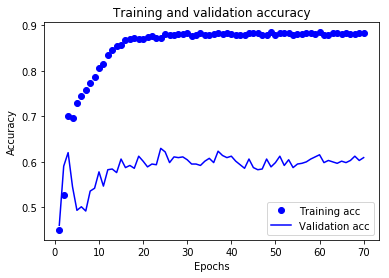

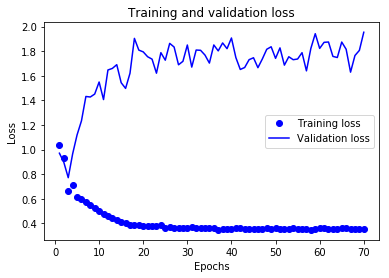

In [50]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Evaluation on test set

In [51]:
results = model.evaluate(X_test, y_test)

800/800 [==============================] - 0s 623us/step


In [52]:
loss = results[0]
accuracy = results[1]

In [53]:
loss

1.8546433973312377

In [54]:
accuracy

0.6175

## Save the model and tokenizer

In [55]:
model.save("HospitalErrorDetectionMultiClassifier.h5")

In [56]:
with open('HospitalErrorDetectionMultiTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)